In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import pickle

In [2]:
from sklearn.preprocessing import LabelEncoder
label=LabelEncoder()

In [3]:
sell_prices=pd.read_csv('sell_prices.csv')
sales_train_validation=pd.read_csv('sales_train_validation.csv')
calendar=pd.read_csv('calendar.csv')
sample=pd.read_csv('sample_submission.csv')

In [4]:
def labeleconder(df, i):
    for col in i:
        not_null = df[col][df[col].notnull()]
        df[col] = pd.Series(label.fit_transform(not_null), index=not_null.index)

    return df

In [5]:
calendar=labeleconder(calendar,["event_name_1", "event_type_1", "event_name_2", "event_type_2"])

In [6]:
drop_col = sales_train_validation.loc[:,"d_1":"d_500"]
sales_train_validation.drop(drop_col, axis=1, inplace=True)

# --------int64 to int16

In [7]:
def reduce(df):
    numeric= ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    for i in df.columns:
        types=df[i].dtypes
        if str(types) in numeric:
            if str(types)[:3] == 'int':
                df[i] = df[i].astype(np.int8)
            if str(types)[:5] == 'float':
                df[i] = df[i].astype(np.float16)
    return df

In [8]:
def reduce_deta(calendar,sell_prices,sales_train_validation):
    numeric= ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    for i in calendar.columns:
        types=calendar[i].dtypes
        if str(types) in numeric:
            if str(types)[:3] == 'int':
                calendar[i] = calendar[i].astype(np.int8)
            if str(types)[:4] == 'float':
                calendar[i] = calendar[i].astype(np.float8)
    for i in sell_prices.columns:
        types=sell_prices[i].dtypes
        if str(types) in numeric:
            if str(types)[:3] == 'int':
                sell_prices[i] = sell_prices[i].astype(np.int8)
            if str(types)[:5] == 'float':
                sell_prices[i] = sell_prices[i].astype(np.float16)
    for i in sales_train_validation.columns:
        types=sales_train_validation[i].dtypes
        if str(types) in numeric:
            if str(types)[:3] == 'int':
                sales_train_validation[i] = sales_train_validation[i].astype(np.int8)
            if str(types)[:5] == 'float':
                sales_train_validation[i] = sales_train_validation[i].astype(np.float8)
    return calendar,sell_prices,sales_train_validation

In [9]:
calendar,sell_prices,sales_train_validation= reduce_deta(calendar,sell_prices,sales_train_validation)

# -------------merge data

In [10]:
def creat_data(sales_train_validation,calendar,sell_prices):
    id_col = ["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"]
    sales_train_validation = sales_train_validation.melt(id_vars=id_col, var_name="d", value_name="demand").pipe(reduce)
    
    data = pd.merge(sales_train_validation, calendar, left_on="d", right_on="d", how="left").pipe(reduce)
    data =pd.merge(data, sell_prices, on = ['store_id', 'item_id', 'wm_yr_wk'], how = 'left').pipe(reduce)
   # data['date']=pd.to_datetime(data['date'])
    return data
    

In [11]:
data=creat_data(sales_train_validation,calendar,sell_prices)

In [12]:
data=reduce(data)

In [13]:
data['date']=pd.to_datetime(data['date'])

In [14]:
data=data.set_index(data['date'],drop=True)

In [15]:
del sales_train_validation,calendar,sell_prices,data['date']
gc.collect()

275

# -----labeleconder and add feature

In [16]:
def add_feature(df):
    df['lag_1'] = df.groupby(['item_id'])['demand'].transform(lambda x: x.shift(1))
    df['lag_7'] = df.groupby(['item_id'])['demand'].transform(lambda x: x.shift(7))
    df['lag_14'] = df.groupby(['item_id'])['demand'].transform(lambda x: x.shift(14))
    df['rolling_mean_t7'] = df.groupby(['item_id'])['demand'].transform(lambda x: x.shift(28).rolling(7).mean())
    df['rolling_mean_t30'] = df.groupby(['item_id'])['demand'].transform(lambda x: x.shift(28).rolling(30).mean())
    df['rolling_mean_t90'] = df.groupby(['item_id'])['demand'].transform(lambda x: x.shift(28).rolling(90).mean())
    df['rolling_mean_t180'] = df.groupby(['item_id'])['demand'].transform(lambda x: x.shift(28).rolling(180).mean())
    df['lag_price_t1'] = df.groupby(['item_id'])['sell_price'].transform(lambda x: x.shift(1))
    df['lag_price_t7'] = df.groupby(['item_id'])['sell_price'].transform(lambda x: x.shift(7))
    df['lag_price_t14'] = df.groupby(['item_id'])['sell_price'].transform(lambda x: x.shift(14))
    return df

In [17]:
data=labeleconder(data,["item_id",'id', "dept_id", "cat_id", "store_id", "state_id",'weekday','d']).pipe(reduce)

In [18]:
data['sell_price'].dropna(how='any',axis=0,inplace=True)

In [19]:
data=add_feature(data).pipe(reduce)

In [20]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49770166 entries, 2012-06-12 to 2016-04-24
Data columns (total 31 columns):
id                   int8
item_id              int8
dept_id              int8
cat_id               int8
store_id             int8
state_id             int8
d                    int8
demand               int8
wm_yr_wk             int8
weekday              int8
wday                 int8
month                int8
year                 int8
event_name_1         float16
event_type_1         float16
event_name_2         float16
event_type_2         float16
snap_CA              int8
snap_TX              int8
snap_WI              int8
sell_price           float16
lag_1                float16
lag_7                float16
lag_14               float16
rolling_mean_t7      float16
rolling_mean_t30     float16
rolling_mean_t90     float16
rolling_mean_t180    float16
lag_price_t1         float16
lag_price_t7         float16
lag_price_t14        float16
dtypes: float16(15),

In [21]:
#finall na
data=data.fillna(0)

In [22]:
del data['d']
gc.collect()

116

In [23]:
data.to_pickle('data.pkl')

In [5]:
data=pd.read_pickle('data.pkl')

# train test-----------------

In [6]:
x_train=data[data.index <= '2016-04-23']

In [7]:
y_train=pd.DataFrame(data['demand'])

In [8]:
y_train=y_train[y_train.index <= '2016-04-23']

In [9]:
x_val = data[(data.index > '2016-04-24') & (data.index <= '2016-05-22')]

In [10]:
y_val = x_val['demand']

In [11]:
y_val=pd.DataFrame(y_val)

In [12]:
del x_train['demand'],x_val['demand']
gc.collect

<function gc.collect(generation=2)>

In [13]:
#normalize

In [14]:
from sklearn import preprocessing

In [15]:
scale = preprocessing.MinMaxScaler( feature_range=(-1,1) )

In [16]:
scale_x_train=scale.fit_transform(x_train)

/home/chinlan102/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int8, float16 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [17]:
scale_y_train=scale.fit_transform(y_train)

/home/chinlan102/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int8 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [18]:
scale_x_val=scale.fit_transform(x_val)

/home/chinlan102/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int8, float16 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [19]:
scale_y_val=scale.fit_transform(y_val)

/home/chinlan102/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int8 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [20]:
#--------

In [21]:
#test = data[(data.index > '2016-04-24')]

In [22]:
scale_x_train, scale_y_train ,scale_x_val= np.array(scale_x_train), np.array(scale_y_train), np.array(scale_x_val)

In [23]:
scale_x_train = np.reshape(scale_x_train, (scale_x_train.shape[0], scale_x_train.shape[1], 1))

In [24]:
scale_x_val = np.reshape(scale_x_val, (scale_x_val.shape[0], scale_x_val.shape[1], 1))

In [25]:
y_train= np.array(y_train)

In [26]:
print(scale_x_train.shape)
print(scale_y_train.shape)
print(scale_x_val.shape)

(48762967, 29, 1)
(48762967, 1)
(1007199, 29, 1)


In [27]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)

(48762967, 29)
(48762967, 1)
(1007199, 29)


In [28]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


In [29]:
regressor=Sequential()

In [30]:
regressor.add(LSTM(units = 50,  input_shape = (x_train.shape[1], 1)))
regressor.add(Dropout(0.01))

regressor.add(Dense(units=256,activation='softplus'))
regressor.add(Dropout(0.01))


regressor.add(Dense(units = 1,activation='softplus'))

In [31]:
regressor.compile(optimizer = 'Nadam', loss = 'mean_squared_error',metrics=["accuracy"])

In [32]:
model=regressor.fit(scale_x_train, y_train, epochs =8, batch_size =1024,validation_split=0.2)

Train on 39010373 samples, validate on 9752594 samples
Epoch 1/8
39010373/39010373 [==============================] - 4499s 115us/step - loss: 12.0157 - accuracy: 0.2733 - val_loss: 10.4413 - val_accuracy: 0.2957
Epoch 2/8
39010373/39010373 [==============================] - 4444s 114us/step - loss: 10.4683 - accuracy: 0.3513 - val_loss: 8.9043 - val_accuracy: 0.3068
Epoch 3/8
39010373/39010373 [==============================] - 4478s 115us/step - loss: 8.7100 - accuracy: 0.4178 - val_loss: 7.8426 - val_accuracy: 0.3822
Epoch 4/8
39010373/39010373 [==============================] - 4486s 115us/step - loss: 7.9758 - accuracy: 0.4306 - val_loss: 7.4441 - val_accuracy: 0.3276
Epoch 5/8
39010373/39010373 [==============================] - 4550s 117us/step - loss: 7.6515 - accuracy: 0.4370 - val_loss: 7.5146 - val_accuracy: 0.3432
Epoch 6/8
39010373/39010373 [==============================] - 4553s 117us/step - loss: 8.5064 - accuracy: 0.4201 - val_loss: 7.5134 - val_accuracy: 0.3660
Epoch 

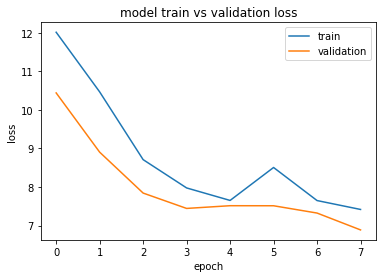

In [48]:
plt.plot(model.history['loss'])
plt.plot(model.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper right')
plt.show()

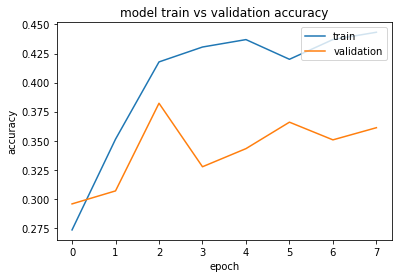

In [49]:
plt.plot(model.history['accuracy'])
plt.plot(model.history['val_accuracy'])
plt.title('model train vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper right')
plt.show()

In [ ]:
#predict val and test

In [33]:
score=regressor.evaluate(scale_x_val,y_val)

1007199/1007199 [==============================] - 192s 191us/step


In [34]:
print('accuracy=',score[1])

accuracy= 0.5145219564437866
